
# <span style="color:rgb(213,80,0)">Multi\-shell acquisitions and micro\-structure models</span>

This demo illustrates most of the functions and utilities in the micro/ folder, i.e, the module related to the computational amalysis of multi\-shell dMRI data. It is based on a linear convolutional model of the so\-called ODF with an elemental impulse response corresponding to a prolate tensor with eigenvalues *lpar* and *lperp*.


In [1]:
addpath('..');
setup__DMRIMatlab_toolbox('useparallel',false); % Will be ingnored if you don't have a licensed copy of the parallel toolbox
clear;
close('all');


















You're running version 1.0 of the toolbox under octave 10.20
Using graphics toolkit: qt




## Load data

Load first your own sutiable multi\-shell dMRI data set, which should include the attenuation signal (DWI over the averaged baseline), the mask to remove the background, the gradients table, and the b\-values for each gradient direction:


In [2]:
tic;
load test_data.mat;
T=toc; % This is always a large piece of data
fprintf(1,'It took %f seconds to load data\n',T);
whos -file test_data.mat; % Check the variables loaded, their kinds, and their sizes





It took 0.969969 seconds to load data

Variables in the file test_data.mat:

variables in scope: test_data.mat

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         atti      101x110x17x256         193402880  single
         bi        256x1                       2048  double
         gi        256x3                       6144  double
         mask      101x110x17                188870  logical

Total is 48540614 elements using 193599942 bytes



## Estimate the micro\-structural model

This section illustrates the usage of the [atti2micro](atti2micro.m) function, which is the core of micro\-structure computation. It returns *f* (the volume fraction of confined, i.e. non\-free water), *lpar*, and *lperp* ( the two eigenvalues of the elemental tensor in the linear convolution model). It is always assured that *mlp*<=*lperp*<=*lpar*<=*ADC0* and that 0<=*f*<=1. In the simplest use case, the function reduces to the original Kaden's method, so that *f*=1 (except for the background) and no regularization is imposed to *lpar* and *lperp*:


In [3]:
tic;
[lpar,lperp,f] = atti2micro( atti, gi, bi, 'tl', 1.0e-6, 'tu', 1-1.0e-6, ...
    'ADC0', 3.0e-3, 'usef', false, 'mask', mask, 'bth', 100, 'mlperp',0.0, ...
    'mu', 0.0, 'verbose', true ); % This is the simplest use case
T = toc; % This is pretty fast...
fprintf(1,'It took %f seconds to complete\n',T);





3 shells detected at b={1000.000, 3000.000, 5000.000} s/mm^2


It took 1.249604 seconds to complete



In this simple case the estimation is pretty fast. Let's check the results:


In [4]:
sl = [5,7,9,11,13,15]; % These are the slices we will show
F = [ f(:,:,sl(1))',f(:,:,sl(2))';f(:,:,sl(3))',f(:,:,sl(4))';f(:,:, ...
    sl(5))',f(:,:,sl(6))']; % Parallel diffusivity
LPA = [ lpar(:,:,sl(1))',lpar(:,:,sl(2))';lpar(:,:,sl(3))',lpar(:,:, ...
    sl(4))';lpar(:,:,sl(5))',lpar(:,:,sl(6))']; % Parallel diffusivity
LPP = [ lperp(:,:,sl(1))',lperp(:,:,sl(2))';lperp(:,:,sl(3))',lperp(:,:, ...
    sl(4))';lperp(:,:,sl(5))',lperp(:,:,sl(6))']; % Perpendicular diffusivity


This is the color map used throughout the demo. It is thought to provide a vast contrast so that subtle changes in the images are highlighted. If it results annoying  to you, change it here:


In [5]:
mapType = 'gray'; % Changing the colormap will trigger the entire demo
switch(mapType)
    case 'high'
        MAP = psychedelia(512);
    case 'gray'
        MAP = gray(512); % B/W colormap
    case 'default'
        MAP = parula(512);
end


Plot the selected slices:














    __axis_label__ at line 38 column 6
    title at line 64 column 3




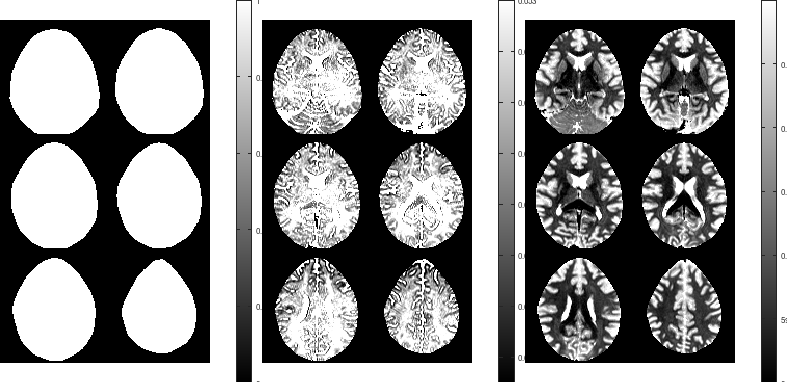

In [6]:
close(figure(1));
hf = figure(1);
set(hf,'Name','micro-structure model','Position',[10,10,700,340]);
R=1; C=3;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(F,[0,1]); colormap(MAP); colorbar; title('f (non-free water)');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(LPA,[1.5e-3,3.0e-3]); colormap(MAP); colorbar; title('\lambda_{||} (mm^2/s)');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(LPP,[0,0.3e-3]); colormap(MAP); colorbar; title('\lambda_{\perp} (mm^2/s)');
axis('equal');axis('off');axis('tight');


Though the estimated values of *lpar* and *lperp* seem quite consistent, there is a fundamental problem with Kaden's method: for regions like the corpus callosum, the value of *lperp* falls down to 0 (or *mlp*, as computed with [atti2micro](atti2micro.m)), so that *rho*=*lperp*/(*lpar*\-*lperp*) and *kappa*=*lpar*/(*lpar*\-*lperp*), which are important parameters in our model, present conflicitive values (0 or 1, respectively) and the calculation of moments becomes singular:


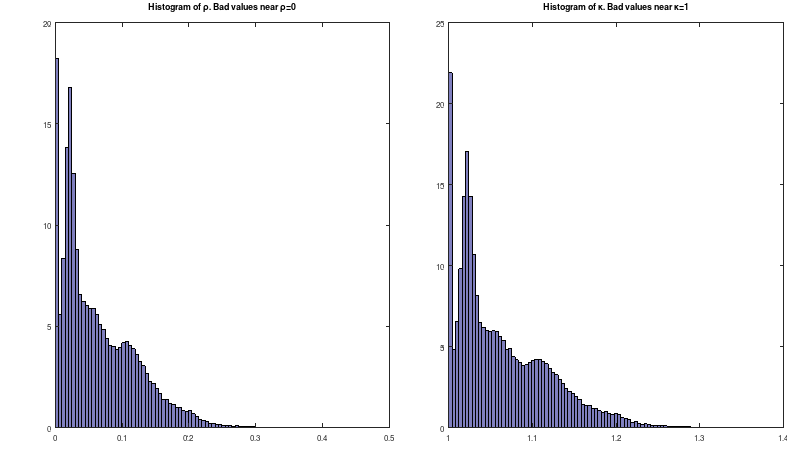

In [7]:
rho = lperp(mask)./(lpar(mask)-lperp(mask));
kappa = lpar(mask)./(lpar(mask)-lperp(mask));
close(figure(2));
hf = figure(2);
set(hf,'Name','Histograms of \rho and \lambda','Position',[10,10,700,400]);
R=1; C=2;
r=1; c=1; subplot('Position',[(c-1)/C+0.07,(r-1)/R+0.05,0.85/C,0.9/R]);
histogram(rho(rho<0.5),100);
title('Histogram of \rho. Bad values near \rho=0');
r=1; c=2; subplot('Position',[(c-1)/C+0.07,(r-1)/R+0.05,0.85/C,0.9/R]);
histogram(kappa(kappa<1.4),100);
title('Histogram of \kappa. Bad values near \kappa=1');


 We will try to remove these 'bad values' by solving a regularized version of the problem where *lperp* is forced to be greater or equal than a given threshold *mlperp* and a penalty term *mu*\*(*lpar*\-*lperp*)/*lperp* = *mu*/ *rho* is added to the cost function (this is not in the orginal Kaden's method):


In [8]:
mu = 0.00015; % Changing the value will trigger the entire demo
tic;
[lpar,lperp,~] = atti2micro( atti, gi, bi, 'tl', 1.0e-6, 'tu', 1-1.0e-6, ...
        'ADC0', 3.0e-3, 'usef', false, 'mask', mask, 'bth', 100, 'mlperp',0.01e-3, ...
        'mu', mu, 'verbose', true ); % We have changed 'mlperp' and 'mu' opt. arguments
T = toc; % Still quite fast
fprintf(1,'It took %f seconds to complete\n',T);






3 shells detected at b={1000.000, 3000.000, 5000.000} s/mm^2


It took 1.152531 seconds to complete



The larger *mu*, the stronger the regularization, so that *lperp* will increase.


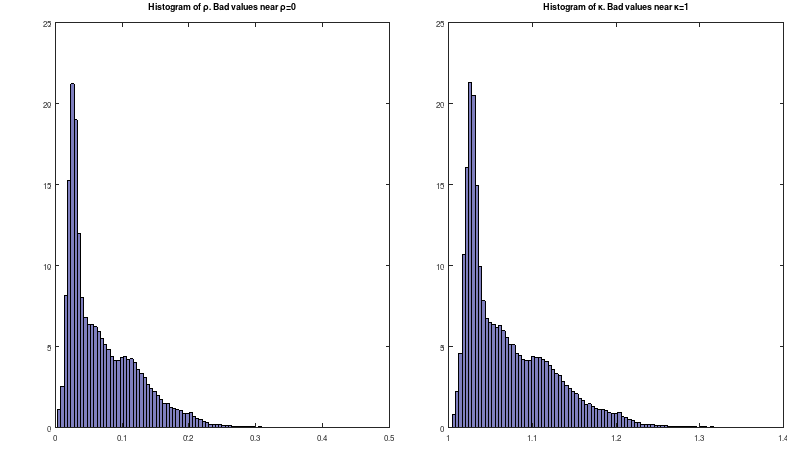

In [9]:
rho = lperp(mask)./(lpar(mask)-lperp(mask)); % rho sholud now avoid conflictive values
kappa = lpar(mask)./(lpar(mask)-lperp(mask)); % kappa sholud now avoid conflictive values
close(figure(3));
hf = figure(3);
set(hf,'Name','Histograms of \rho and \lambda','Position',[10,10,700,400]);
R=1; C=2;
r=1; c=1; subplot('Position',[(c-1)/C+0.07,(r-1)/R+0.05,0.85/C,0.9/R]);
histogram(rho(rho<0.5),100);
title('Histogram of \rho. Bad values near \rho=0');
r=1; c=2; subplot('Position',[(c-1)/C+0.07,(r-1)/R+0.05,0.85/C,0.9/R]);
histogram(kappa(kappa<1.4),100);
title('Histogram of \kappa. Bad values near \kappa=1');


A further refinement not present in Kaden's original work is the possibility to isolate a compartment with free\-water, i.e. diffusion outside the neural axons. This is dramatically slower since a greedy search in *f* is performed. Besides, parallel computing doesn't seem to help here because it is hard to keep all matlab's workers busy:






3 shells detected at b={1000.000, 3000.000, 5000.000} s/mm^2


It took 6.807737 seconds to complete





















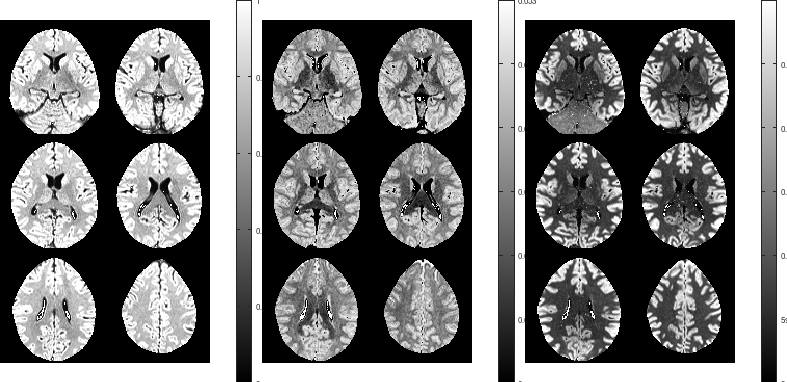

In [10]:
tic;
[lpar,lperp,f] = atti2micro( atti, gi, bi, 'tl', 1.0e-6, 'tu', 1-1.0e-6, ...
    'ADC0', 3.0e-3, 'usef', true, 'regf', true,'mask', mask, 'bth', 100, ...
    'mlperp',0.01e-3, 'mu', mu, 'verbose', true ); % We have changed the 'usef' opt. argument
T = toc;
fprintf(1,'It took %f seconds to complete\n',T);
F = [ f(:,:,sl(1))',f(:,:,sl(2))';f(:,:,sl(3))',f(:,:,sl(4))';f(:,:, ...
    sl(5))',f(:,:,sl(6))']; % Parallel diffusivity
LPA = [ lpar(:,:,sl(1))',lpar(:,:,sl(2))';lpar(:,:,sl(3))',lpar(:,:, ...
    sl(4))';lpar(:,:,sl(5))',lpar(:,:,sl(6))']; % Parallel diffusivity
LPP = [ lperp(:,:,sl(1))',lperp(:,:,sl(2))';lperp(:,:,sl(3))',lperp(:,:, ...
    sl(4))';lperp(:,:,sl(5))',lperp(:,:,sl(6))']; % Perpendicular diffusivity
close(figure(4));
hf = figure(4);
set(hf,'Name','micro-structure + free-water model','Position',[10,10,700,340]);
R=1; C=3;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(F,[0,1]); colormap(MAP); colorbar; title('f (non-free water)');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(LPA,[0.0e-3,3.0e-3]); colormap(MAP); colorbar; title('\lambda_{||} (mm^2/s)');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(LPP,[0,0.3e-3]); colormap(MAP); colorbar; title('\lambda_{\perp} (mm^2/s)');
axis('equal');axis('off');axis('tight');


It seems the free\-water elimination is not a great idea, since the micro\-structural model looks far too noisy. Besides, the value of *f* is strangely low at the corpus callosum, which indeed corrupts the micro\-structural model yielding to very small, questionable values of *lpar*. This might be a matter of parameter tunning, since no effort has been made to check the effect of *mu*, *lperp*, *tl*, *tu*, etcetera on the estimated model. By now, we will just revert the last step and keep the mono\-compartment, regularized model:






3 shells detected at b={1000.000, 3000.000, 5000.000} s/mm^2


It took 1.196457 seconds to complete




















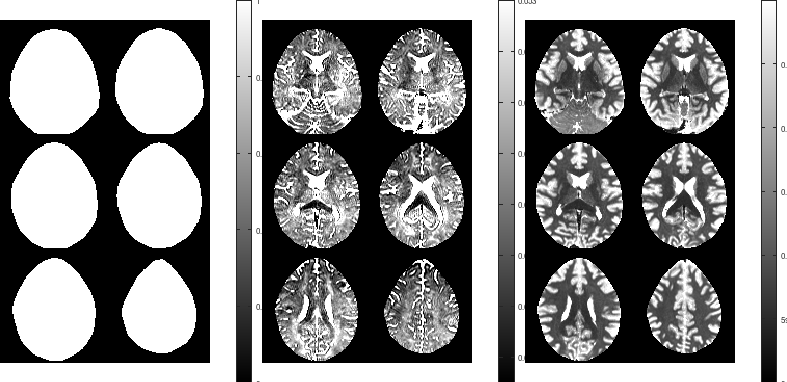

In [11]:
tic;
[lpar,lperp,f] = atti2micro( atti, gi, bi, 'tl', 1.0e-6, 'tu', 1-1.0e-6, ...
    'ADC0', 3.0e-3, 'usef', false, 'mask', mask, 'bth', 100, 'mlperp',0.01e-3, ...
    'mu', 5.0e-4, 'verbose', true ); % No longer use the 'usef' flag
T = toc; % Which is indeed very fast!
fprintf(1,'It took %f seconds to complete\n',T);
F = [ f(:,:,sl(1))',f(:,:,sl(2))';f(:,:,sl(3))',f(:,:,sl(4))';f(:,:, ...
    sl(5))',f(:,:,sl(6))']; % Parallel diffusivity
LPA = [ lpar(:,:,sl(1))',lpar(:,:,sl(2))';lpar(:,:,sl(3))',lpar(:,:, ...
    sl(4))';lpar(:,:,sl(5))',lpar(:,:,sl(6))']; % Parallel diffusivity
LPP = [ lperp(:,:,sl(1))',lperp(:,:,sl(2))';lperp(:,:,sl(3))',lperp(:,:, ...
    sl(4))';lperp(:,:,sl(5))',lperp(:,:,sl(6))']; % Perpendicular diffusivity
hf = figure(5);
set(hf,'Name','Regularized micro-structure model','Position',[10,10,700,340]);
R=1; C=3;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(F,[0,1]); colormap(MAP); colorbar; title('f (non-free water)');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(LPA,[1.5e-3,3.0e-3]); colormap(MAP); colorbar; title('\lambda_{||} (mm^2/s)');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc(LPP,[0,0.3e-3]); colormap(MAP); colorbar; title('\lambda_{\perp} (mm^2/s)');
axis('equal');axis('off');axis('tight');

## ODFs estimation

Once the micro\-structure model is available, computing the ODFs field is a spherical deconvolution problem. Since we are using Spherical Harmonics, this is a trivial task that reduces to a linear LS fitting of SH coefficients. The present section illustrates how to use the function [micro2shodf](micro2shodf.m). This may take a good while since we invert one matrix per voxel:


In [12]:
tic; %
sh = micro2shodf( atti, gi, bi, lpar, lperp, [], 'L', 8, 'tl', 1.0e-6, 'tu', ...
    1-1.0e-6, 'mask', mask,'optimal', true, 'lambda', 0.0005 ); % The 'optimal' flag means one matrix is inverted at each voxel
T = toc;
fprintf(1,'It took %f seconds to compute the ODFs\n',T);




    compute_shodf_from_micro at line 86 column 13
    micro2shodf at line 183 column 1

    compute_shodf_from_micro at line 86 column 13
    micro2shodf at line 183 column 1

    compute_shodf_from_micro at line 86 column 13
    micro2shodf at line 183 column 1

    compute_shodf_from_micro at line 86 column 13
    micro2shodf at line 183 column 1

    compute_shodf_from_micro at line 86 column 13
    micro2shodf at line 183 column 1

    compute_shodf_from_micro at line 86 column 13
    micro2shodf at line 183 column 1



It took 11.332653 seconds to compute the ODFs



You can speed\-up this computation by using a parallel implementation based on parfor loops. You just have to properly set\-up the toolbox via: [setup\_\_DMRIMatlab\_toolbox](setup__DMRIMatlab_toolbox.m)<u>('useparallel',true);</u> We can now visually check the results with our built\-in plot feature:


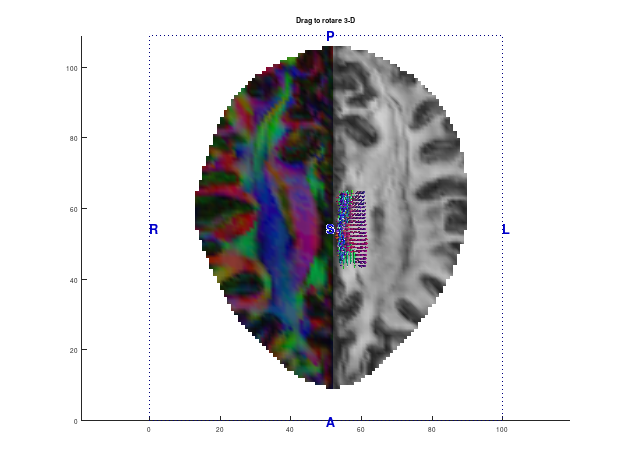

In [13]:
close(figure(1)); close(figure(2)); % Close previous figures if necessary
hf = figure(1); ha = axes('Parent',hf);
sl = 14; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh,[1,mx],[1,110],[sl,sl],'bgimage', 'color', 'bgsh', sh, 'ha', ...
    ha, 'bgalpha', 1, 'mask', mask, 'bbox', true, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3) ); % color-by-orientation half the slice
plotdmri3d(sh,[mx,101],[1,110],[sl,sl],'bgimage', 'fa', 'bgsh', sh, 'ha', ...
    ha,'bgalpha', 0.9, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh,[mx+2,mx+8],[45,65],[sl,sl],'ha',ha, 'bgimage', 'fa', 'bgsh', ...
    sh, 'bgalpha', 0, 'mask', mask, 'bbox', false, 'glyphs', true, 'angleres', ...
    642, 'glyphspc', [1;1;1], 'glyphsc', 2,'glyphscvar', 'none', 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light; % Even cooler look
axis('equal');
rotate3d('on');
title('Drag to rotare 3-D');


The color\-by\-orientation, FA, and ODFs field look quite reasonable even without any denoising (this is not always the case with HARDI). To avoid the large computation time associated to the inversion of the LS matrix at each voxel, we may think of a sub\-optimal scheme where only one matrix is pre\-computed and inverted for the whole data set:







It took 0.998513 seconds to compute the ODFs



















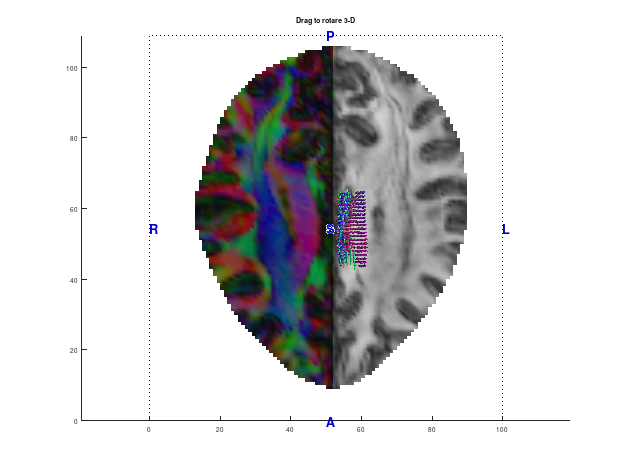

In [14]:
tic;
sh2 = micro2shodf( atti, gi, bi, lpar, lperp, [], 'L', 8, 'tl', 1.0e-6, 'tu', ...
    1-1.0e-6, 'mask', mask,'optimal', false, 'lambda', 0.0005 ); % Note 'optimal' is now false and we use 'reweight'
T = toc; % This is pretty faster
fprintf(1,'It took %f seconds to compute the ODFs\n',T);
close(figure(2)); % Close previous figures if necessary
hf = figure(2); ha = axes('Parent',hf);
sl = 14; mx = 53; % Select the piece of data to plot with our cool plotdmri3d
plotdmri3d(sh2,[1,mx],[1,110],[sl,sl],'bgimage', 'color', 'bgsh', sh2, ...
    'ha', ha, 'bgalpha', 1, 'mask', mask, 'bbox', true, 'glyphs', false, ...
    'origin',[0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3) ); % color-by-orientation half the slice
plotdmri3d(sh2,[mx,101],[1,110],[sl,sl],'bgimage', 'fa', 'bgsh', sh2, 'ha', ...
    ha,'bgalpha', 0.9, 'mask', mask, 'bbox', false, 'glyphs', false, 'origin', ...
    [0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % FA image for the other half of the slice
plotdmri3d(sh2,[mx+2,mx+8],[45,65],[sl,sl],'ha',ha, 'bgimage', 'fa', ...
    'bgsh', sh2, 'bgalpha', 0, 'mask', mask, 'bbox', false, 'glyphs', true, ...
    'angleres', 642, 'glyphspc', [1;1;1], 'glyphsc', 2,'glyphscvar', 'none', ...
    'origin',[0;0;0],'direction',eye(3),'space','LPS','mframe',eye(3)  ); % Cool ODF glyphs in the CC and CG
light % Even cooler look
axis('equal');
rotate3d('on');
title('Drag to rotare 3-D');


The results look pretty similar to those obtained with the optimal estimation method, both for the color\-coded/FA maps and the ODFs field. However, we will keep by now the result of the optimal estimation method and discard the other one:


In [15]:
clear sh2;

## Characterization of diffusion via moments computation. Full moments

The next three sections illustrate the computation of arbitrary order moments to characterize the diffusion process, i.e., they illustrate the usage of [micro2moments](micro2moments.m). We start with the so\-called 'full moments', computed as integrals in the whole 3\-D space of either the attenaution signal or the EAP. This kind of moments depend just on the micro\-structure (*lpar* and *lperp*) and not on the ODF. For the attenaution signal, E(q):


In [16]:
tic;
UEm2 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Ef', 'nu', -2 ); % Orders >-3 are allowed
T = toc; % For integer nu, the computation is quite fast
fprintf(1,'It took %f seconds to compute the moment\n',T);
UEm1 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Ef', 'nu', -1, 'clean', 100 );  % Potentiate small q
UEp0 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Ef', 'nu', 0,  'clean', 100 );  % This is just RTOP
UEp1 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Ef', 'nu', 1,  'clean', 100 );  % Potentiate far-from-zero q
UEp2 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Ef', 'nu', 2,  'clean', 100 );  % This is just QMSD





It took 1.539194 seconds to compute the moment







This computation is very fast, since it is a trivial manipulation of *lperp* and *lpar*. Of course, different moments provide different contrast features:


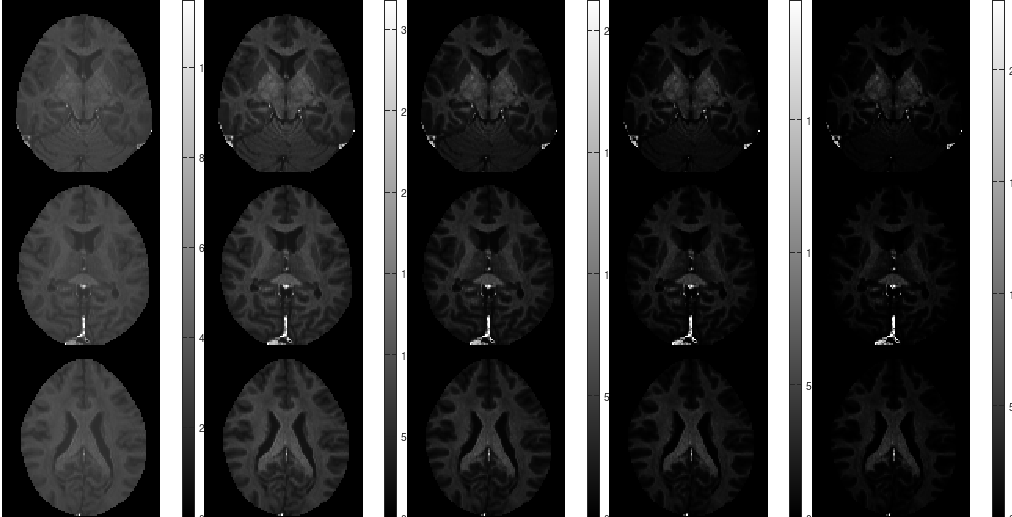

In [17]:
sl = [4,8,12]; % Slices to plot
close(figure(1)); close(figure(2)); % Close previous figures if needed
hf = figure(1);
set(hf,'Name','Full moments over E(q)','Position',[10,10,900,460]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEm2(:,:,sl(1))';UEm2(:,:,sl(2))';UEm2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon^{-2}');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEm1(:,:,sl(1))';UEm1(:,:,sl(2))';UEm1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon^{-1}');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp0(:,:,sl(1))';UEp0(:,:,sl(2))';UEp0(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon^{0} = RTOP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp1(:,:,sl(1))';UEp1(:,:,sl(2))';UEp1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon^{1}');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp2(:,:,sl(1))';UEp2(:,:,sl(2))';UEp2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon^{2} = QMSD');
axis('equal');axis('off');axis('tight');


The computation for the EAP is analogous, but the features highlighted are completely different:


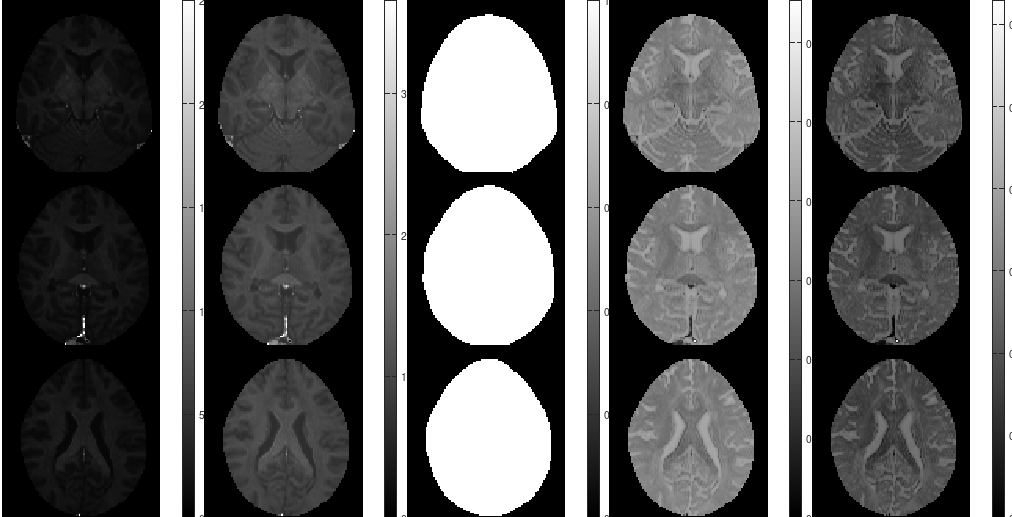

In [18]:
UPm2 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Pf', 'nu', -2 ); % Orders >-3 are allowed
UPm1 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Pf', 'nu', -1 ); % Potentiate small R
UPp0 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Pf', 'nu', 0 );  % This is just 1!!!
UPp1 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Pf', 'nu', 1 );  % Potentiate far-from-zero R
UPp2 = micro2moments( [], lpar, lperp, [], 'mask', mask, 'type', 'Pf', 'nu', 2 );  % This is just MSD
sl = [4,8,12]; % Slices to plot
hf = figure(2);
set(hf,'Name','Full moments over P(R)','Position',[10,10,900,460]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPm2(:,:,sl(1))';UPm2(:,:,sl(2))';UPm2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon^{-2}');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPm1(:,:,sl(1))';UPm1(:,:,sl(2))';UPm1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon^{-1}');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp0(:,:,sl(1))';UPp0(:,:,sl(2))';UPp0(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon^{0} = 1');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp1(:,:,sl(1))';UPp1(:,:,sl(2))';UPp1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon^{1}');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp2(:,:,sl(1))';UPp2(:,:,sl(2))';UPp2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon^{2} = MSD');
axis('equal');axis('off');axis('tight');

## Axial moments

Axial moments depend on a direction provided at each voxel, typically the direction of maximum diffusion. But they could be otherwise computed over vector fields computed from tractography, or over any other meaningful vector field:


In [19]:
tens = shadc2dti(sh,'mask',mask,'unroll',false ); % Compute a tensor field from the SH volume
u0 = dti2xyz( tens, 'mask', mask ); % Maximum diffusion direction


[dti2xyz](dti2xyz.m) also benefits from parallel computations, but it is no big deal since the function itself is quite fast.


Axial moments will depend on both the micro\-structure model and the ODF. Begin with E(q):


In [20]:
tic; % Non-integer moments take far longer to compute because of the usage of hypergeom
UEm12 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ea', 'nu', -1/2, 'u0', u0 ); % Orders >-1 are allowed
T = toc;
fprintf(1,'It took %f seconds to compute the moment\n',T);
UEm14 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ea', 'nu', -1/4, 'u0', u0, 'clean', 100 ); % Potentiate small q
UEp0  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ea', 'nu', 0, 'u0', u0,    'clean', 100 ); % This is just RTPP
UEp1  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ea', 'nu', 1, 'u0', u0,    'clean', 100 ); % Potentiate far-from-zero q
UEp2  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ea', 'nu', 2, 'u0', u0,    'clean', 100 ); % Potentiate farther-from-zero q





It took 3.505894 seconds to compute the moment







Though non\-integer moments imply the computation of hypergeometric functions, we provide an efficient algorithm for the special case 2F1 in the function [dmri\_2F1](dmri_2F1.m), so that the overload is not that important.


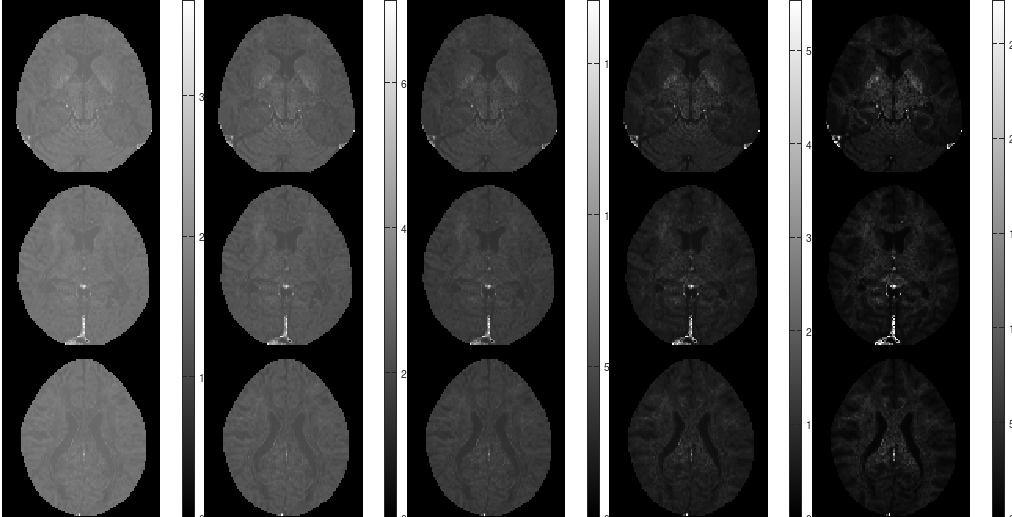

In [21]:
sl = [4,8,12]; % Slices to plot
close(figure(1)); close(figure(2)); % Close previous figures if needed
hf = figure(1);
set(hf,'Name','Axial moments over E(q)','Position',[10,10,900,460]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEm12(:,:,sl(1))';UEm12(:,:,sl(2))';UEm12(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_a^{-1/2}');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEm14(:,:,sl(1))';UEm14(:,:,sl(2))';UEm14(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_a^{-1/4}');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp0(:,:,sl(1))';UEp0(:,:,sl(2))';UEp0(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_a^{0} = \upsilon_p^{0}=RTPP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp1(:,:,sl(1))';UEp1(:,:,sl(2))';UEp1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_a^{1}');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp2(:,:,sl(1))';UEp2(:,:,sl(2))';UEp2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_a^{2}');
axis('equal');axis('off');axis('tight');


Moments related to the EAP are computed in the same way:


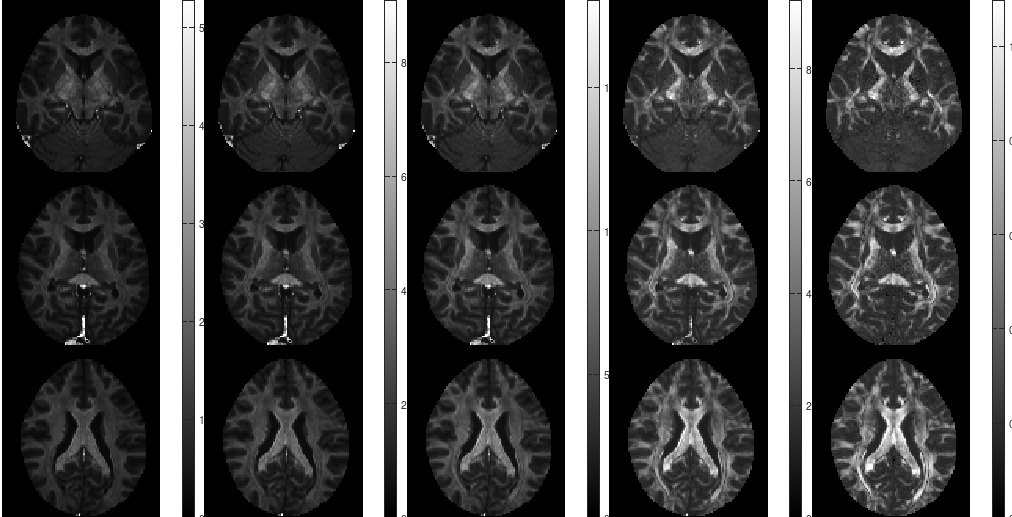

In [22]:
UPm12 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pa', 'nu', -1/2, 'u0', u0, 'clean',  100 ); % Orders >-1 are allowed
UPm14 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pa', 'nu', -1/4, 'u0', u0, 'clean',  100 ); % Potentiate small q
UPp0  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pa', 'nu', 0, 'u0', u0,    'clean',  100 );
UPp1  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pa', 'nu', 1, 'u0', u0,    'clean',  100 ); % Potentiate far-from-zero q
UPp2  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pa', 'nu', 2, 'u0', u0,    'clean',  100 ); % Potentiate farther-from-zero q
sl = [4,8,12]; % Slices to plot
hf = figure(2);
set(hf,'Name','Axial moments over P(R)','Position',[10,10,900,460]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPm12(:,:,sl(1))';UPm12(:,:,sl(2))';UPm12(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_a^{-1/2}');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPm14(:,:,sl(1))';UPm14(:,:,sl(2))';UPm14(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_a^{-1/4}');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp0(:,:,sl(1))';UPp0(:,:,sl(2))';UPp0(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_a^{0} = \Upsilon_p^{0} = RTAP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp1(:,:,sl(1))';UPp1(:,:,sl(2))';UPp1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_a^{1}');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp2(:,:,sl(1))';UPp2(:,:,sl(2))';UPp2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_a^{2}');
axis('equal');axis('off');axis('tight');

## Planar moments

Planar moments depend on a direction provided at each voxel, typically the direction of maximum diffusion. But they could be otherwise computed over vector fields computed from tractography, or over any other meaningful vector field. Planar moments will depend on both the micro\-structure model and the ODF. Begin with E(q):


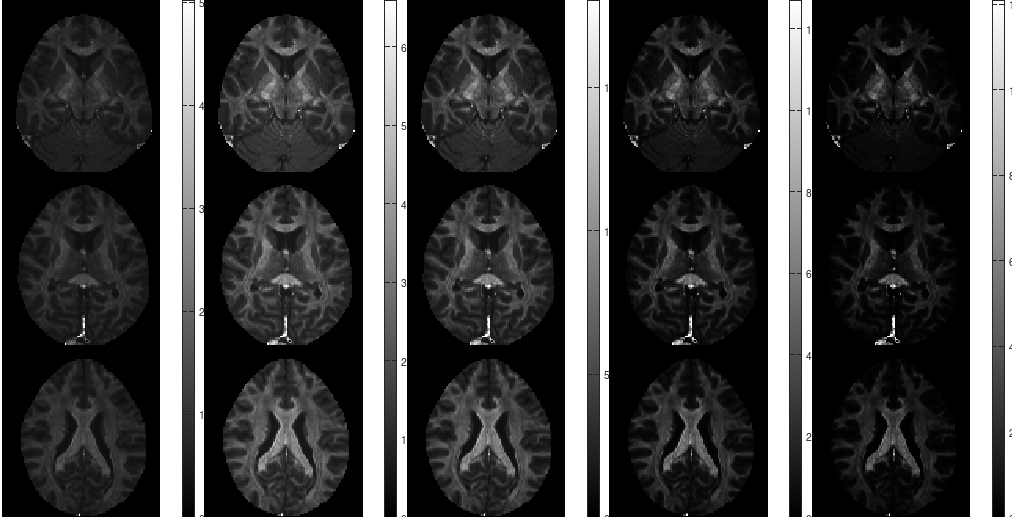

In [23]:
UEm12 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ep', 'nu', -1/2, 'u0', u0, 'clean',  100 ); % Orders >-2 are allowed
UEm14 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ep', 'nu', -1/4, 'u0', u0, 'clean',  100 ); % Potentiate small q
UEp0  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ep', 'nu', 0, 'u0', u0,    'clean',  100 ); % This is just RTAP
UEp1  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ep', 'nu', 1, 'u0', u0,    'clean',  100 ); % Potentiate far-from-zero q
UEp2  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Ep', 'nu', 2, 'u0', u0,    'clean',  100 ); % Potentiate farther-from-zero q
sl = [4,8,12]; % Slices to plot
close(figure(1)); close(figure(2));
hf = figure(1);
set(hf,'Name','Planar moments over E(q)','Position',[10,10,900,460]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEm12(:,:,sl(1))';UEm12(:,:,sl(2))';UEm12(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_p^{-1/2}');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEm14(:,:,sl(1))';UEm14(:,:,sl(2))';UEm14(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_p^{-1/4}');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp0(:,:,sl(1))';UEp0(:,:,sl(2))';UEp0(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_p^{0} = \upsilon_a^{0}=RTAP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp1(:,:,sl(1))';UEp1(:,:,sl(2))';UEp1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_p^{1}');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UEp2(:,:,sl(1))';UEp2(:,:,sl(2))';UEp2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\Upsilon_p^{2}');
axis('equal');axis('off');axis('tight');


The same can be done for the EAP, P(R):


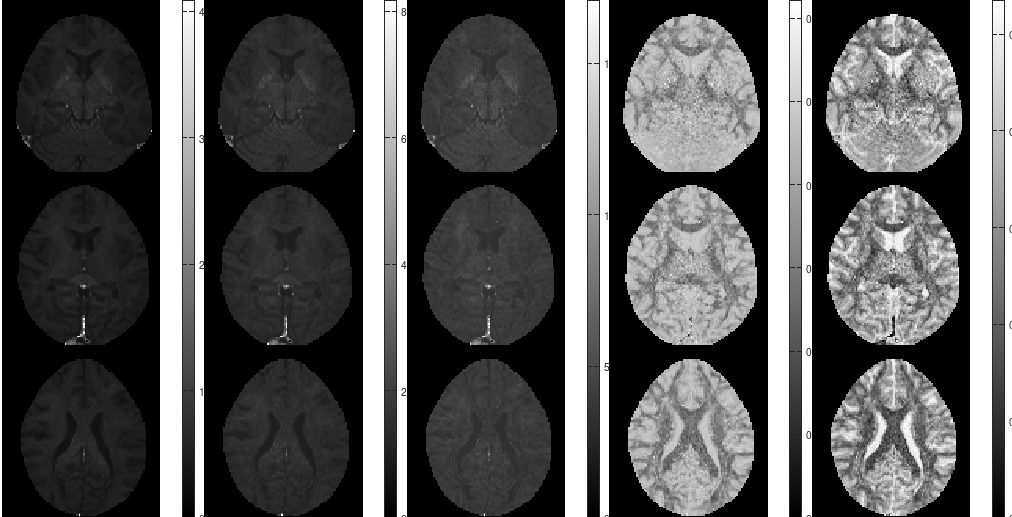

In [24]:
UPm12 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pp', 'nu', -1/2, 'u0', u0, 'clean',  100 ); % Orders >-2 are allowed
UPm14 = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pp', 'nu', -1/4, 'u0', u0, 'clean',  100 ); % Potentiate small q
UPp0  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pp', 'nu', 0, 'u0', u0,    'clean',  100 );
UPp1  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pp', 'nu', 1, 'u0', u0,    'clean',  100 ); % Potentiate far-from-zero q
UPp2  = micro2moments( sh, lpar, lperp, [], 'mask', mask, 'type', 'Pp', 'nu', 2, 'u0', u0,    'clean',  100 ); % Potentiate farther-from-zero q
sl = [4,8,12]; % Slices to plot
hf = figure(2);
set(hf,'Name','Planar moments over P(R)','Position',[10,10,900,460]);
R=1; C=5;
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPm12(:,:,sl(1))';UPm12(:,:,sl(2))';UPm12(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_p^{-1/2}');
axis('equal');axis('off');axis('tight');
r=1; c=2; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPm14(:,:,sl(1))';UPm14(:,:,sl(2))';UPm14(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_p^{-1/4}');
axis('equal');axis('off');axis('tight');
r=1; c=3; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp0(:,:,sl(1))';UPp0(:,:,sl(2))';UPp0(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_p^{0} = \Upsilon_a^{0} = RTPP');
axis('equal');axis('off');axis('tight');
r=1; c=4; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp1(:,:,sl(1))';UPp1(:,:,sl(2))';UPp1(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_p^{1}');
axis('equal');axis('off');axis('tight');
r=1; c=5; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
imagesc([UPp2(:,:,sl(1))';UPp2(:,:,sl(2))';UPp2(:,:, ...
    sl(3))';]); colormap(MAP); colorbar; title('\upsilon_p^{2}');
axis('equal');axis('off');axis('tight');


Finally note that for *nu=0* there is a direct relationship between planar moments computed over E(q) and axial moments compute over P(R) (and vice\-versa) by virtue of the central section theorem. More concretely:

-  The axial moment of order *nu=0* computed over E(q) will equal the planar moment of order *nu=0* computed over P(R) (this is just RTPP).
-  The planar moment of order *nu=0* computed over E(q) will equal the axial moment of order *nu=0* computed over P(R) (this is just RTAP).
## Propagator Anisotropy

The PA is related to the distance from the EAP (or, equivalently, E(q)) to its isotropic equivalent defined as its spherical average. In our framework, this reduces once again to a manipulation of the SH coefficients. In this case there is not an analytical closed\-form available, so the calculations rely on precomputed integrals implemented in [dmri\_compute\_PA\_weights](dmri_compute_PA_weights.m). However, it is unlikely that you need to explicitly call that function, since it will be invoked as needed by [micro2pa](micro2pa.m), which is the function we illustrate in this section. In the simplest case,




    micro2pa at line 104 column 9



It took 1.090243 seconds to compute the PA









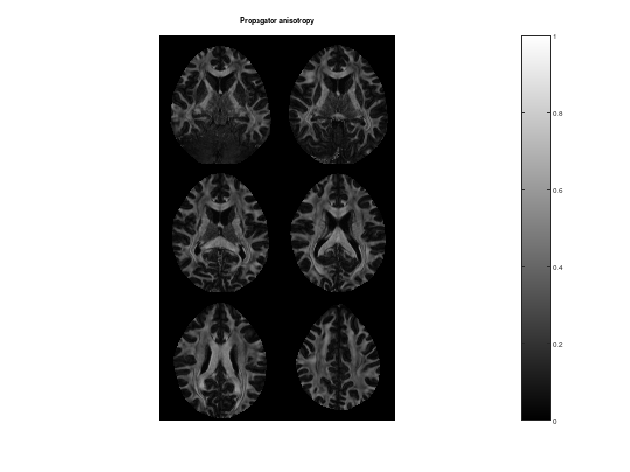

In [25]:
tic;
pa = micro2pa( sh, lpar, lperp, 'mask', mask, 'epsilon', [] );
T = toc; % This is pretty fast
fprintf(1,'It took %f seconds to compute the PA\n',T);
close(figure(1));
figure(1);
sl = [5,7,9,11,13,15]; % These are the slices we will show
PA = [ pa(:,:,sl(1))',pa(:,:,sl(2))';pa(:,:,sl(3))',pa(:,:,sl(4))';pa(:,:, ...
    sl(5))',pa(:,:,sl(6))'];
imagesc(PA,[0,1]); colormap(MAP); colorbar; title('Propagator anisotropy');
axis('equal');axis('off');axis('tight');


However, the raw values of the PA are not well distributed over the range \[0,1\], so that a gamma correction is usually applied to improve its visual performance. You can fix this by properly tunning the optional input parameter *epsilon*:



    micro2pa at line 104 column 9









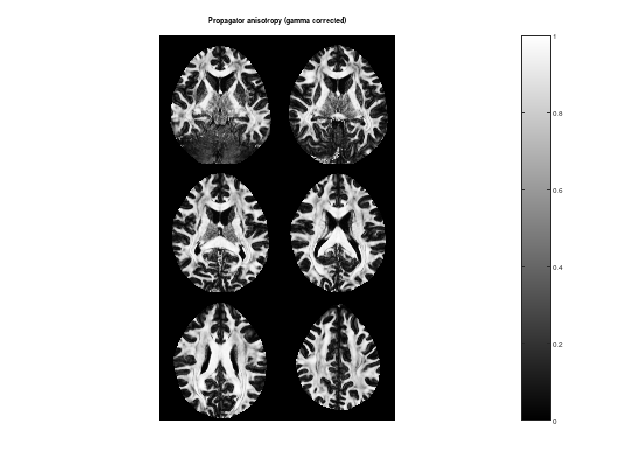

In [26]:
pa = micro2pa( sh, lpar, lperp, 'mask', mask, 'epsilon', 0.4 );
figure(1);
sl = [5,7,9,11,13,15]; % These are the slices we will show
PA = [ pa(:,:,sl(1))',pa(:,:,sl(2))';pa(:,:,sl(3))',pa(:,:,sl(4))';pa(:,:, ...
    sl(5))',pa(:,:,sl(6))'];
imagesc(PA,[0,1]); colormap(MAP); colorbar; title('Propagator anisotropy (gamma corrected)');
axis('equal');axis('off');axis('tight');


Finally, we can as well compute the PA at a microscopic level, i.e., compute the PA of the elemental tensor that describes the linear convolution model. The optional input argument *micro* is used to that end. Note in this case the ODF is not relevant at all, so you can pass an empty array as the first input argument:


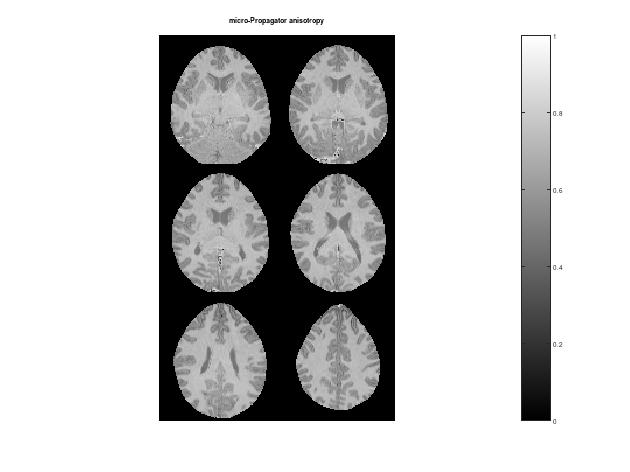

In [27]:
pa = micro2pa( [], lpar, lperp, 'mask', mask, 'epsilon', [], 'micro', true );
figure(1);
sl = [5,7,9,11,13,15]; % These are the slices we will show
PA = [ pa(:,:,sl(1))',pa(:,:,sl(2))';pa(:,:,sl(3))',pa(:,:,sl(4))';pa(:,:, ...
    sl(5))',pa(:,:,sl(6))'];
imagesc(PA,[0,1]); colormap(MAP); colorbar; title('micro-Propagator anisotropy');
axis('equal');axis('off');axis('tight');


In this case the gamma correction (not shown) is a total disgrace. On the other hand, the raw\-micro\-PA doesn't seem very informative irself. It makes kind of sense, since at the end of the day we are just computing something related to the anisotropy of the elemental diffusion tensor, which we now is vastly prolate beforehand.

## Non\-gaussianity

The NG is related to the distance from the EAP (or, equivalently, E(q)) to its *Gaussian equivalent*, which may be estimated in several ways. In our framework, this reduces once again to a manipulation of the SH coefficients. In this case there is not an analytical closed\-form available, so the calculations rely on precomputed integrals implemented in [dmri\_compute\_PA\_weights](dmri_compute_PA_weights.m). However, it is unlikely that you need to explicitly call that function, since it will be invoked as needed by [micro2ng](micro2ng.m), which is the function we illustrate in this section. In the simplest case,






It took 2.370232 seconds to reconstruct E(q) from the model





It took 2.207190 seconds to compute the tensor model


    micro2ng at line 121 column 5



It took 1.881969 seconds to compute the NG









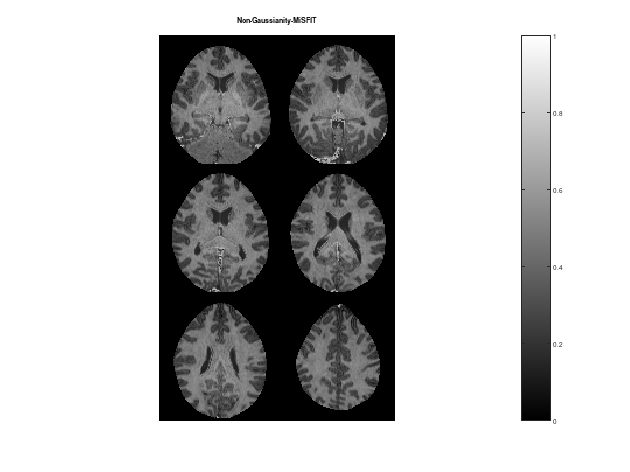

In [28]:
tic;
atti2 = micro2atti(sh, lpar, lperp, [], gi(bi<=1999,:), bi(bi<=1999,:), 'mask', mask );
T = toc;
fprintf(1,'It took %f seconds to reconstruct E(q) from the model\n',T);
tic;
sh2 = atti2shadc( atti2, gi(bi<=1999,:), bi(bi<=1999,:), 'mask', mask, 'L', 2 , 'lambda', 0.0001 );
dti = shadc2dti(sh2, 'mask', mask ,'unroll', false);
T = toc;
fprintf(1,'It took %f seconds to compute the tensor model\n',T);
tic;
ng = micro2ng( sh, lpar, lperp, dti, 'mask', mask, 'epsilon',[], 'lambda', 1.0e-9 );
T = toc;
fprintf(1,'It took %f seconds to compute the NG\n',T);
close(figure(1));
hf = figure(1);
set(hf,'Name','Non-Gaussianity');
NG = [ ng(:,:,sl(1))',ng(:,:,sl(2))';ng(:,:,sl(3))',ng(:,:,sl(4))';ng(:,:, ...
    sl(5))',ng(:,:,sl(6))'];
imagesc(NG,[0,1]); colormap(MAP); colorbar; title('Non-Gaussianity-MiSFIT');
axis('equal');axis('off');axis('tight');